In [5]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import sys
import math

import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import glob

#import albumentations as A
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
#from albumentations.pytorch import ToTensorV2
from sklearn.metrics import roc_auc_score
from torch.optim import lr_scheduler
from tqdm import tqdm
import re
import random
import cv2
from torch.utils.data import Dataset
import monai
import matplotlib as plt

sys.path.append("../utils")
from classifier_utils import *

In [6]:
NUM_IMAGES_3D = 64
TRAINING_BATCH_SIZE = 4
TEST_BATCH_SIZE = 4
IMAGE_SIZE = 256
N_EPOCHS = 15
do_valid = True
n_workers = 4
type_ = "T1wCE"

In [7]:
def load_dicom_image(path, img_size=IMAGE_SIZE, voi_lut=True, rotate=0, get_slice_thickness=False):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array

    if rotate > 0:
        rot_choices = [
            0,
            cv2.ROTATE_90_CLOCKWISE,
            cv2.ROTATE_90_COUNTERCLOCKWISE,
            cv2.ROTATE_180,
        ]
        data = cv2.rotate(data, rot_choices[rotate])

    data = cv2.resize(data, (img_size, img_size))
    #data = cv2.resize(data, (int(math.ceil(data.shape[1]*dicom.PixelSpacing[1])), int(math.ceil(data.shape[0]*dicom.PixelSpacing[0]))))
    diff_0 = (img_size - data.shape[0]) // 2
    diff_1 = (img_size - data.shape[1]) // 2
    data = np.pad(data, ((diff_0,diff_0),(diff_1,diff_1)), 'minimum')  
        
    if get_slice_thickness:
        return data, dicom.SliceThickness
    else:
        return data

In [8]:
class BrainRSNADataset(Dataset):
    def __init__(
        self, data, transform=None, target="MGMT_value", mri_type="FLAIR", is_train=True
    ):
        self.target = target
        self.data = data
        self.type = mri_type

        self.transform = transform
        self.is_train = is_train
        self.folder = "train" if self.is_train else "test"

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.loc[index]
        case_id = int(row.BraTS21ID)
        target = int(row[self.target])
        _3d_images = self.load_dicom_images_3d(case_id)
        _3d_images = torch.tensor(_3d_images).float()
        if self.is_train:
            return {"image": _3d_images, "target": target}
        else:
            return {"image": _3d_images, "case_id": case_id}

    def load_dicom_images_3d(
        self,
        case_id,
        num_imgs=NUM_IMAGES_3D,
        img_size=IMAGE_SIZE,
        rotate=0,
    ):
        case_id = str(case_id).zfill(5)

        path = f"../../RSNA-BTC-Datasets/{self.folder}/{case_id}/{self.type}/*.dcm"
        #path = f"/media/salvatorecapuozzo/DA2C9A532C9A2A91/{self.folder}/{case_id}/{self.type}/*.dcm"
        files = sorted(
            glob.glob(path),
            key=lambda var: [
                int(x) if x.isdigit() else x for x in re.findall(r"[^0-9]|[0-9]+", var)
            ],
        )

        middle = len(files) // 2
        num_imgs2 = num_imgs // 2
        p1 = max(0, middle - num_imgs2)
        p2 = min(len(files), middle + num_imgs2)
        image_stack = [load_dicom_image(f, rotate=rotate) for f in files[p1:p2]]
        
        img3d = np.stack(image_stack).T
        if img3d.shape[-1] < num_imgs:
            n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
            img3d = np.concatenate((img3d, n_zero), axis=-1)

        if np.min(img3d) < np.max(img3d):
            img3d = img3d - np.min(img3d)
            img3d = img3d / np.max(img3d)

        return np.expand_dims(img3d, 0)

In [11]:
# model 
model = monai.networks.nets.resnet10(spatial_dims=3, n_input_channels=1, n_classes=1)
device = torch.device("cuda")
model.to(device)
# Downloaded weights
#weights_path = "../../RSNA-BTC-Datasets/tunisiaai_resnet10_rsna_weights"
# Trained weights
weights_path = "../../RSNA-BTC-Datasets/rsnaresnet10_output_weights"
all_weights = os.listdir(weights_path)
fold_files = [f for f in all_weights if type_ in f]
criterion = nn.BCEWithLogitsLoss()

In [15]:
fold_files_f = []
for fold in fold_files:
    if "3d-resnet10_T1wCE" in fold:
        fold_files_f.append(fold)
        
fold_files_f

['3d-resnet10_T1wCE_fold0_0.576.pth',
 '3d-resnet10_T1wCE_fold2_0.528.pth',
 '3d-resnet10_T1wCE_fold4_0.571.pth',
 '3d-resnet10_T1wCE_fold3_0.651.pth',
 '3d-resnet10_T1wCE_fold1_0.612.pth']

In [16]:
sample = pd.read_csv("../sample_submission.csv")

In [17]:
tta_true_labels = []
tta_preds = []
test_dataset = BrainRSNADataset(data=sample, mri_type=type_, is_train=False)
test_dl = torch.utils.data.DataLoader(
        test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=4
    )

preds_f = np.zeros(len(sample))
for fold in range(5):
    image_ids = []
    model.load_state_dict(torch.load(f"{weights_path}/{fold_files[fold]}"))
    preds = []
    epoch_iterator_test = tqdm(test_dl)
    with torch.no_grad():
        for  step, batch in enumerate(epoch_iterator_test):
            model.eval()
            images = batch["image"].to(device)

            outputs = model(images)
            preds.append(outputs.sigmoid().detach().cpu().numpy())
            image_ids.append(batch["case_id"].detach().cpu().numpy())
    

    preds_f += np.vstack(preds).T[0]/5

    ids_f = np.hstack(image_ids)

100%|███████████████████████████████████████████| 22/22 [00:06<00:00,  3.21it/s]


In [18]:
hl = pd.read_csv("../hl_test_set.csv")

sample["BraTS21ID"] = ids_f
sample["MGMT_value"] = preds_f
sample["rounded_MGMT_value"] = [1 if x > 0.5 else 0 for x in preds_f]
sample["MGMT_HL_value"] = hl["MGMT_value"]

sample = sample.sort_values(by="BraTS21ID").reset_index(drop=True)
sample_file = sample[["BraTS21ID","MGMT_value"]].sort_values(by="BraTS21ID").reset_index(drop=True)
#sample_file.to_csv("submission.csv", index=False)

In [19]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
sample

,BraTS21ID,MGMT_value,rounded_MGMT_value,MGMT_HL_value
0,1,0.603890,1,1
1,13,0.627597,1,1
2,15,0.623734,1,1
3,27,0.629567,1,1
4,37,0.614393,1,1
5,47,0.632806,1,1
6,79,0.632553,1,1
7,80,0.618493,1,1
8,82,0.627586,1,1
9,91,0.612774,1,1


In [20]:
count_0 = [1 if x > 0.5 else 0 for x in preds_f].count(0)
count_1 = [1 if x > 0.5 else 0 for x in preds_f].count(1)
print(f"Predictions: {count_0} without tumor, {count_1} with tumor")
hl_count_0 = hl["MGMT_value"].tolist().count(0)
hl_count_1 = hl["MGMT_value"].tolist().count(1)
print(f"Hand Labeling: {hl_count_0} without tumor, {hl_count_1} with tumor")
y = list(hl["MGMT_value"])

Predictions: 9 without tumor, 78 with tumor
Hand Labeling: 33 without tumor, 54 with tumor


Confusion matrix, without normalization


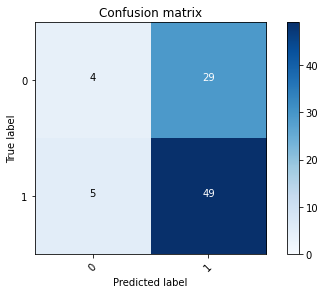

In [21]:
rounded_preds_f = [1 if x > 0.5 else 0 for x in preds_f]
plot_confusion_matrix(y, rounded_preds_f)

In [22]:
auc = roc_auc_score(y, preds_f)
acc = [1 if yy == out else 0 for (yy,out) in zip(y,rounded_preds_f)].count(1)/len(preds_f)
total_0_count = y.count(0)
total_1_count = y.count(1)
total_1_pred_count = rounded_preds_f.count(1)
true_0 = [1 if yy == out and yy == 0 else 0 for (yy,out) in zip(y,rounded_preds_f)].count(1)
true_1 = [1 if yy == out and yy == 1 else 0 for (yy,out) in zip(y,rounded_preds_f)].count(1)
spec = true_0/total_0_count
sens = true_1/total_1_count
if total_1_pred_count != 0:
    prec = true_1/total_1_pred_count
else:
    prec = 0
if prec+sens == 0:
    f1_score = 0
else:
    f1_score = 2*prec*sens/(prec+sens)
bal_acc = (spec+sens)/2
print(f"Prediction AUC: {auc:.4f}")
print(f"Prediction Accuracy: {acc:.4f}")
print(f"Prediction Specificity: {spec:.4f}")
print(f"Prediction Sensitivity: {sens:.4f}")
print(f"Prediction Precision: {prec:.4f}")
print(f"Prediction F1-score: {f1_score:.4f}")
print(f"Prediction Balanced Accuracy: {bal_acc:.4f}")

Prediction AUC: 0.6493
Prediction Accuracy: 0.6092
Prediction Specificity: 0.1212
Prediction Sensitivity: 0.9074
Prediction Precision: 0.6282
Prediction F1-score: 0.7424
Prediction Balanced Accuracy: 0.5143
